<a href="https://colab.research.google.com/github/hamagami/is2024/blob/main/06_DecisionTree_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06 Decision Tree classification by scratch

In [ ]:
import numpy as np
import pandas as pd
from collections import Counter

## Decision tree scratch function, class

In [ ]:
# Function to calculate entropy
def entropy(y):
    counts = Counter(y)
    probabilities = [count / len(y) for count in counts.values()]
    return -sum(p * np.log2(p) for p in probabilities if p > 0)

# Function to calculate information gain
def information_gain(y, y_left, y_right):
    p = len(y_left) / len(y)
    return entropy(y) - p * entropy(y_left) - (1 - p) * entropy(y_right)

# Custom Decision Tree class with entropy-based splits
class DecisionTreeScratch:
    def __init__(self, max_depth=3):
        self.max_depth = max_depth
        self.tree = None

    class Node:
        def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
            self.feature = feature
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value

        def is_leaf_node(self):
            return self.value is not None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def _best_split(self, X, y):
        best_gain = -1
        best_feature, best_threshold = None, None
        n_features = X.shape[1]

        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                right_mask = X[:, feature] > threshold
                y_left, y_right = y[left_mask], y[right_mask]

                if len(y_left) == 0 or len(y_right) == 0:
                    continue

                gain = information_gain(y, y_left, y_right)
                if gain > best_gain:
                    best_gain = gain
                    best_feature, best_threshold = feature, threshold

        return best_feature, best_threshold

    def _build_tree(self, X, y, depth=0):
        num_samples_per_class = Counter(y)
        predicted_class = max(num_samples_per_class, key=num_samples_per_class.get)
        node = self.Node(value=predicted_class)

        # Stop if max depth is reached or no further split is possible
        if depth < self.max_depth:
            feature, threshold = self._best_split(X, y)
            if feature is not None:
                left_mask = X[:, feature] <= threshold
                right_mask = X[:, feature] > threshold
                left = self._build_tree(X[left_mask], y[left_mask], depth + 1)
                right = self._build_tree(X[right_mask], y[right_mask], depth + 1)
                return self.Node(feature, threshold, left, right)
        return node

    def predict(self, X):
        return [self._predict_single(self.tree, x) for x in X]

    def _predict_single(self, node, x):
        if node.is_leaf_node():
            return node.value
        if x[node.feature] <= node.threshold:
            return self._predict_single(node.left, x)
        else:
            return self._predict_single(node.right, x)

### Go-out data

In [ ]:
# Example usage with dataset
data = {
    'Weather': ['Sunny', 'Sunny', 'Rainy', 'Rainy', 'Cloudy', 'Cloudy', 'Sunny', 'Rainy', 'Cloudy', 'Sunny'],
    'Wind': ['Strong', 'Weak', 'Strong', 'Weak', 'Weak', 'Strong', 'Weak', 'Strong', 'Weak', 'Strong'],
    'Humidity': ['High', 'High', 'High', 'Low', 'Low', 'High', 'Low', 'Low', 'High', 'Low'],
    'Go_Out': ['No', 'Yes', 'No', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes']
}

df = pd.DataFrame(data)

# Convert categorical data to numerical
df['Weather'] = df['Weather'].map({'Sunny': 0, 'Rainy': 1, 'Cloudy': 2})
df['Wind'] = df['Wind'].map({'Weak': 0, 'Strong': 1})
df['Humidity'] = df['Humidity'].map({'Low': 0, 'High': 1})
df['Go_Out'] = df['Go_Out'].map({'No': 0, 'Yes': 1})

X = df[['Weather', 'Wind', 'Humidity']].values
y = df['Go_Out'].values

## classsification

In [4]:
# Fitting the custom Decision Tree
tree_scratch = DecisionTreeScratch(max_depth=3)
tree_scratch.fit(X, y)

# Predicting on the dataset
predictions = tree_scratch.predict(X)
print(predictions)


[0, 1, 0, 0, 1, 0, 1, 0, 1, 1]


# visualization

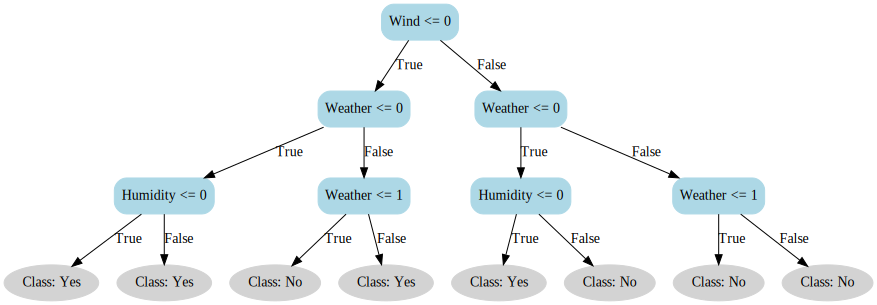

In [3]:
# Helper function to visualize the tree structure created from scratch
import graphviz

def visualize_tree(node, feature_names, class_names):
    def add_nodes_edges(dot, node, parent=None, edge_label=""):
        if node is None:
            return

        node_id = str(id(node))
        if node.is_leaf_node():
            label = f"Class: {class_names[node.value]}"
            dot.node(node_id, label, shape="ellipse", style="filled", color="lightgrey")
        else:
            label = f"{feature_names[node.feature]} <= {node.threshold}"
            dot.node(node_id, label, shape="box", style="rounded, filled", color="lightblue")

        if parent is not None:
            dot.edge(str(id(parent)), node_id, label=edge_label)

        if node.left:
            add_nodes_edges(dot, node.left, node, "True")
        if node.right:
            add_nodes_edges(dot, node.right, node, "False")

    dot = graphviz.Digraph()
    add_nodes_edges(dot, node)
    return dot

# Feature and class names
feature_names = ['Weather', 'Wind', 'Humidity']
class_names = ['No', 'Yes']

# Visualize the custom-built decision tree
tree_visualization = visualize_tree(tree_scratch.tree, feature_names, class_names)

# Displaying the visualization directly as SVG
from IPython.display import SVG, display

tree_visualization.format = "svg"
svg_path = tree_visualization.render(filename="/mnt/data/custom_decision_tree", format="svg")
display(SVG(svg_path))
